In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import timm
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("✅ Device:", device)


✅ Device: cuda


In [8]:
backbone = timm.create_model(
    'vit_base_patch14_dinov2.lvd142m',
    pretrained=True,
    num_classes=0
).to(device)


In [9]:
class DinoClassifier(nn.Module):
    def __init__(self, backbone, num_classes=4):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)
        return self.head(feats)


model = DinoClassifier(backbone, num_classes=4).to(device)


In [10]:
checkpoint = torch.load("app/models/best_dino_base_518.pth", map_location=device)

# Remove old classification head
filtered_state = {
    k: v for k, v in checkpoint.items()
    if not k.startswith("head.")
}

missing, unexpected = model.load_state_dict(filtered_state, strict=False)

print("✅ Loaded pretrained backbone weights")
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)


✅ Loaded pretrained backbone weights
Missing keys: ['head.0.weight', 'head.0.bias', 'head.1.weight', 'head.1.bias', 'head.1.running_mean', 'head.1.running_var', 'head.4.weight', 'head.4.bias', 'head.7.weight', 'head.7.bias']
Unexpected keys: []


In [11]:
for param in model.backbone.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True


In [12]:
train_transform = T.Compose([
    T.RandomResizedCrop(518, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(0.2, 0.2, 0.2),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize((518, 518)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])


In [13]:
data_path = r"D:\dermora-app\backend\dataset"

full_train_ds = ImageFolder(
    os.path.join(data_path, "train"),
    transform=train_transform
)

val_ratio = 0.2
val_size = int(len(full_train_ds) * val_ratio)
train_size = len(full_train_ds) - val_size

train_ds, val_ds = random_split(
    full_train_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# IMPORTANT: validation uses test transforms
val_ds.dataset.transform = test_transform

test_ds = ImageFolder(
    os.path.join(data_path, "test"),
    transform=test_transform
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)

class_names = full_train_ds.classes
print("✅ Classes:", class_names)


✅ Classes: ['eczema', 'normal', 'psoriasis', 'vitiligo']


In [14]:
print(full_train_ds.class_to_idx)


{'eczema': 0, 'normal': 1, 'psoriasis': 2, 'vitiligo': 3}


In [15]:
from collections import Counter
labels = [label for _, label in full_train_ds.samples]
print(Counter(labels))


Counter({1: 1651, 2: 1644, 0: 1341, 3: 399})


In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.head.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=2, factor=0.5
)


In [17]:
def train_epoch(model, loader):
    model.train()
    total, correct, loss_sum = 0, 0, 0

    pbar = tqdm(loader, desc="Training", leave=False)

    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss_sum += loss.item()

        # 🔥 force visible updates
        pbar.set_postfix(
            acc=f"{correct/total:.3f}",
            loss=f"{loss_sum/(pbar.n+1):.3f}"
        )

    return correct / total, loss_sum / len(loader)

def validate_epoch(model, loader):
    model.eval()
    total, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validation", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [18]:
best_acc = 0
epochs = 5

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_loader)
    val_acc = validate_epoch(model, val_loader)

    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Acc: {train_acc:.4f} | Loss: {train_loss:.4f}")
    print(f"Val   Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_dino_with_normal.pth")
        print("💾 Saved best model")


Epoch 1/5
Train Acc: 0.9387 | Loss: 0.2015
Val   Acc: 0.9712
💾 Saved best model


Epoch 2/5
Train Acc: 0.9628 | Loss: 0.1016
Val   Acc: 0.9782
💾 Saved best model


Epoch 3/5
Train Acc: 0.9687 | Loss: 0.0892
Val   Acc: 0.9881
💾 Saved best model


Epoch 4/5
Train Acc: 0.9737 | Loss: 0.0767
Val   Acc: 0.9692


Epoch 5/5
Train Acc: 0.9729 | Loss: 0.0822
Val   Acc: 0.9841


In [19]:
for block in model.backbone.blocks[-2:]:
    for param in block.parameters():
        param.requires_grad = True

optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5,
    weight_decay=1e-4
)

print("✅ Fine-tuning last 2 transformer blocks")


✅ Fine-tuning last 2 transformer blocks


In [20]:
best_acc = 0
epochs = 5

for epoch in range(epochs):
    train_acc, train_loss = train_epoch(model, train_loader)
    val_acc = validate_epoch(model, val_loader)

    print(f"[Phase-2] Epoch {epoch+1}/{epochs}")
    print(f"Train Acc: {train_acc:.4f}")
    print(f"Val   Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_dino_finetuned.pth")
        print("💾 Saved fine-tuned model")


[Phase-2] Epoch 1/5
Train Acc: 0.9821
Val   Acc: 0.9861
💾 Saved fine-tuned model


[Phase-2] Epoch 2/5
Train Acc: 0.9809
Val   Acc: 0.9851


[Phase-2] Epoch 3/5
Train Acc: 0.9849
Val   Acc: 0.9901
💾 Saved fine-tuned model


[Phase-2] Epoch 4/5
Train Acc: 0.9834
Val   Acc: 0.9911
💾 Saved fine-tuned model


[Phase-2] Epoch 5/5
Train Acc: 0.9854
Val   Acc: 0.9921
💾 Saved fine-tuned model



📊 Classification Report:

              precision    recall  f1-score   support

      eczema       0.89      0.89      0.89       168
      normal       0.93      0.99      0.96       189
   psoriasis       0.91      0.90      0.90       206
    vitiligo       1.00      0.95      0.97       239

    accuracy                           0.94       802
   macro avg       0.93      0.93      0.93       802
weighted avg       0.94      0.94      0.94       802



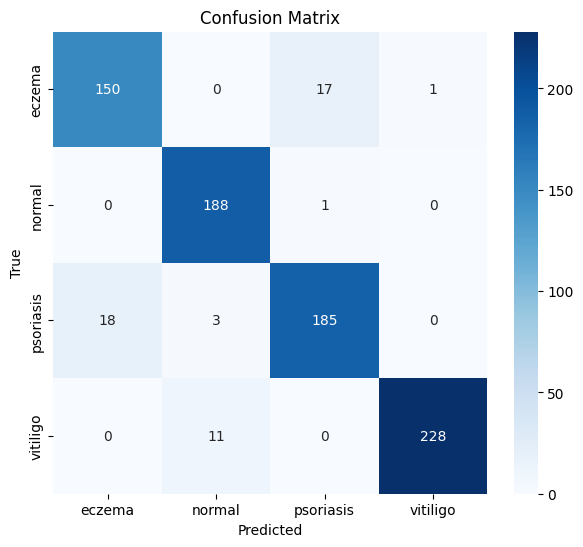

In [21]:
model.load_state_dict(torch.load("best_dino_finetuned.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        preds = model(imgs).argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
